## TP n° 1 : Manipulation de données audio : classification stylistique


### - Partie 1 : Manipulation de fichiers audio

In [65]:
!pip install playsound
!pip install matplotlib
!pip install seaborn
!pip install librosa

Audio time series: [1.0904326e-03 1.3623741e-03 1.4456341e-03 ... 4.1513053e-06 4.0163877e-06
 3.6187041e-06];
Number of samples: 11819689;
Sample rate: 44100;

Calculated audio duration: 268.0202 seconds;
Expected duration: 268 seconds.


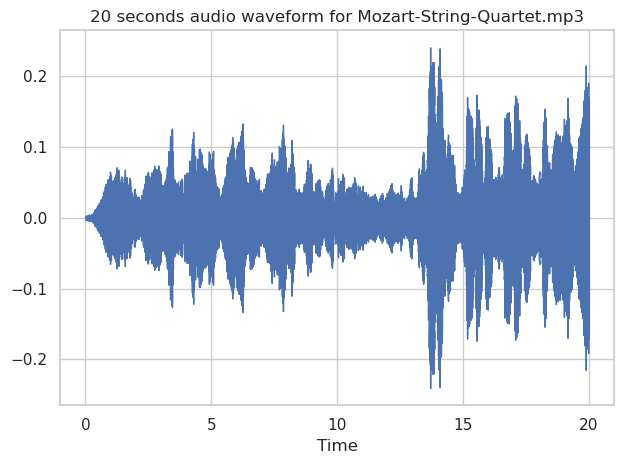

In [66]:
from playsound import playsound
import matplotlib.pyplot as plt
import seaborn as sns
from librosa import load
from librosa.display import waveshow, specshow

# Define the path to the audio file
audio_path = './audio/classique/Mozart-String-Quartet.mp3'

# Uncomment the line below to play the audio
# playsound(audio_path)

# Load the audio file
audio_data, sample_rate = load(audio_path, sr=None)
print(f"Audio time series: {audio_data};\nNumber of samples: {len(audio_data)};\nSample rate: {sample_rate};\n")

# Calculate the duration of the audio
audio_length = len(audio_data) / sample_rate
print(f"Calculated audio duration: {audio_length:.4f} seconds;\nExpected duration: 268 seconds.")

# Load only the first 20 seconds of the audio
short_audio_data, short_sample_rate = load(audio_path, duration=20.0, sr=None)

# Set the style for seaborn plots
sns.set_style("whitegrid")

# Display the waveform of the first 20 seconds of the audio
waveshow(short_audio_data, sr=short_sample_rate, max_points=4000, color='b')
plt.title(f"20 seconds audio waveform for {audio_path.split('/')[-1]}")
plt.tight_layout()

### - Partie 2 : Représentation MFCCs

MFCC matrix: [[-6.3108276e+02 -6.2340741e+02 -6.2859424e+02 ... -4.2355289e+02
  -4.1231015e+02 -4.0191470e+02]
 [ 9.0284470e+01  7.9042953e+01  7.0759697e+01 ...  2.1299614e+02
   2.1250070e+02  2.0048016e+02]
 [ 2.1121704e+01  6.2669029e+00  3.9824321e+00 ... -1.7736706e+01
  -2.0703897e+01 -1.3364901e+01]
 ...
 [ 5.2292500e+00  1.9074188e+01  2.9117142e+01 ... -4.4705477e+00
  -5.2679420e+00 -5.8305111e+00]
 [ 7.9767876e+00  1.3579590e+01  1.9681330e+01 ...  4.2926445e+00
   2.1332188e+00  1.1907628e-01]
 [ 7.1455927e+00  9.1086006e-01  2.9571569e+00 ... -3.4895406e+00
  -5.8292809e+00 -1.3436276e+00]], shape: (12, 862)
86.2 values per second per coefficient.
One value in MFCC for one coefficient corresponds to 511.6009280742459 samples.


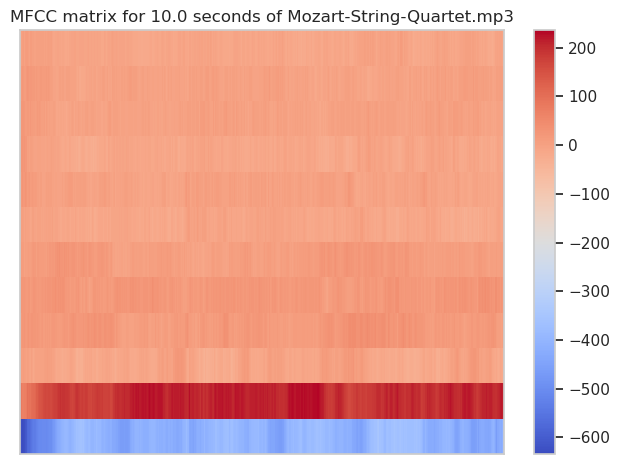

In [67]:
from librosa.feature import mfcc

n_bande_freq = 12
duration_ = 10.0

# Load the audio file for the specified duration
ts, sr = load(audio_path, duration=duration_, sr=None)

# Compute the MFCCs
mfcc_ = mfcc(y=ts, sr=sr, n_mfcc=n_bande_freq)
print(f"MFCC matrix: {mfcc_}, shape: {mfcc_.shape}")

# Calculate the number of values per second for each coefficient
values_per_second = mfcc_.shape[1] / duration_
print(f"{values_per_second} values per second per coefficient.")

# Calculate the number of audio samples corresponding to one value
samples_per_value = sr / values_per_second
print(f"One value in MFCC for one coefficient corresponds to {samples_per_value} samples.")

# Display the MFCC matrix
specshow(mfcc_, sr=sr)
plt.title(f"MFCC matrix for {duration_} seconds of {audio_path.split('/')[-1]}")
plt.colorbar()
plt.tight_layout()
plt.show()

### - Partie 3 : Préparation des descripteurs

Standard deviations: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Means: [ 0.0000000e+00  0.0000000e+00  1.3276209e-08  1.7701611e-08
  4.4254027e-09 -8.8508054e-09 -8.8508054e-09  8.8508054e-09
 -1.3276209e-08 -4.4254027e-09 -4.4254027e-09  0.0000000e+00]


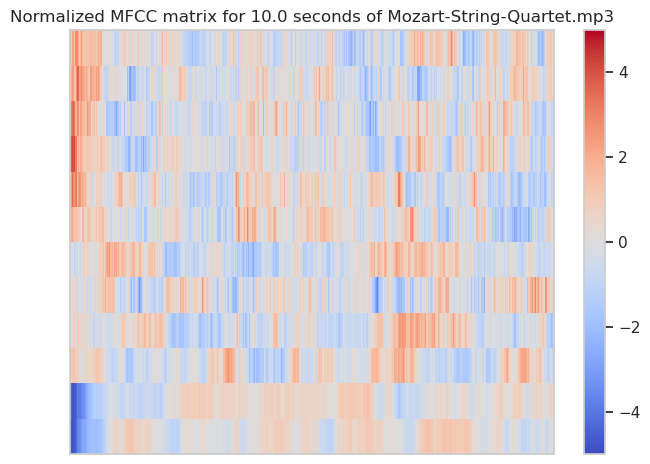

In [68]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define the function to compute and normalize MFCCs
def compute_and_normalize_mfcc(audio_path: str, n_mfcc: int, duration: float) -> np.ndarray:
    # Load the audio file for the specified duration
    ts, sr = load(audio_path, duration=duration, sr=None)
    
    # Compute the MFCCs
    mfcc_ = mfcc(y=ts, sr=sr, n_mfcc=n_mfcc)
    
    # Standardize the MFCC matrix
    std_scaler = StandardScaler()
    mfcc_T = mfcc_.T  # Transpose the MFCC matrix to have shape (n_samples, n_features)
    mfcc_std = std_scaler.fit_transform(mfcc_T)
    
    # Verify the normalization
    print(f"Standard deviations: {np.std(mfcc_std, axis=0)}")
    print(f"Means: {np.mean(mfcc_std, axis=0)}")
    
    return mfcc_std

# Example usage
audio_path = './audio/classique/Mozart-String-Quartet.mp3'
n_mfcc = 12
duration = 10.0

# Compute and normalize MFCCs
normalized_mfcc = compute_and_normalize_mfcc(audio_path, n_mfcc, duration)

# Display the normalized MFCC matrix
specshow(normalized_mfcc.T, sr=sr)  # Transpose back for visualization
plt.title(f"Normalized MFCC matrix for {duration} seconds of {audio_path.split('/')[-1]}")
plt.colorbar()
plt.tight_layout()
plt.show()

### - Partie 4 : Entraînement d'un modèle

In [69]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from librosa import load, feature

np.random.seed(2024)

def load_and_extract_mfcc(fnames: List[str], n_desc: int, duration: float, offset: float = 0.0) -> np.ndarray:
    acc = []
    for fname in fnames:
        ts, sr = load(fname, sr=None, duration=duration, offset=offset)
        mfcc_ = feature.mfcc(y=ts, sr=sr, n_mfcc=n_desc)
        acc.append(mfcc_.T)
    
    # Merge all MFCCs
    merged_mfccs = np.concatenate(acc, axis=0)
    print(f"{merged_mfccs.shape = }")
    
    # Standardize the merged MFCC matrix
    std_scaler = StandardScaler()
    mfcc_std = std_scaler.fit_transform(merged_mfccs)
    print(f"{mfcc_std.shape = }")
    return mfcc_std

def create_dataframe(mfcc_std: np.ndarray, targets: List[np.ndarray]) -> pd.DataFrame:
    merged_targets = np.concatenate(targets)
    print(f"{merged_targets.shape = }")
    indices = np.arange(mfcc_std.shape[0])
    np.random.shuffle(indices)
    shuffled_mfccs = mfcc_std[indices]
    shuffled_targets = merged_targets[indices]
    data = pd.DataFrame(shuffled_mfccs)
    data['target'] = shuffled_targets
    return data

def train_classifier(data: pd.DataFrame, classifier):
    X_train = data.drop('target', axis=1)
    y_train = data['target']
    classifier.fit(X_train, y_train)
    return classifier

def evaluate_classifier(classifier, X, y):
    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    return accuracy, report, cm

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Parameters
n_desc = 128
duration = 20
fnames = ["./audio/classique/Mozart-String-Quartet.mp3", "./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3"]

# Load and extract MFCCs
mfccs = load_and_extract_mfcc(fnames, n_desc, duration)
targets = [np.zeros(mfccs.shape[0]//2, dtype=int), np.ones(mfccs.shape[0]//2, dtype=int)]
data = create_dataframe(mfccs, targets)

# Train classifiers
svm_clf = train_classifier(data, SVC(C=1.0, kernel='rbf', random_state=2024))
rf_clf = train_classifier(data, RandomForestClassifier(n_estimators=100, random_state=2024))

# Evaluate classifiers on training data
X_train = data.drop('target', axis=1)
y_train = data['target']

accuracy_svc, report_svc, cm_svc = evaluate_classifier(svm_clf, X_train, y_train)
accuracy_rf, report_rf, cm_rf = evaluate_classifier(rf_clf, X_train, y_train)

print("SVC Classification Report:")
print(report_svc)
print("RandomForest Classification Report:")
print(report_rf)

merged_mfccs.shape = (3446, 128)
mfcc_std.shape = (3446, 128)
merged_targets.shape = (3446,)
SVC Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1723
           1       1.00      1.00      1.00      1723

    accuracy                           1.00      3446
   macro avg       1.00      1.00      1.00      3446
weighted avg       1.00      1.00      1.00      3446

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1723
           1       1.00      1.00      1.00      1723

    accuracy                           1.00      3446
   macro avg       1.00      1.00      1.00      3446
weighted avg       1.00      1.00      1.00      3446



### - Partie 5 : Évaluation d'un modèle

merged_mfccs.shape = (862, 128)
mfcc_std.shape = (862, 128)
merged_targets.shape = (3446,)
SVC Accuracy: 50.00%
RandomForest Accuracy: 49.42%
SVC Classification report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67       862
           1       0.00      0.00      0.00         0

    accuracy                           0.50       862
   macro avg       0.50      0.25      0.33       862
weighted avg       1.00      0.50      0.67       862

RandomForest Classification report:
              precision    recall  f1-score   support

           0       1.00      0.49      0.66       862
           1       0.00      0.00      0.00         0

    accuracy                           0.49       862
   macro avg       0.50      0.25      0.33       862
weighted avg       1.00      0.49      0.66       862



/home/mkherraz001/miniconda3/envs/audio_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mkherraz001/miniconda3/envs/audio_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mkherraz001/miniconda3/envs/audio_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

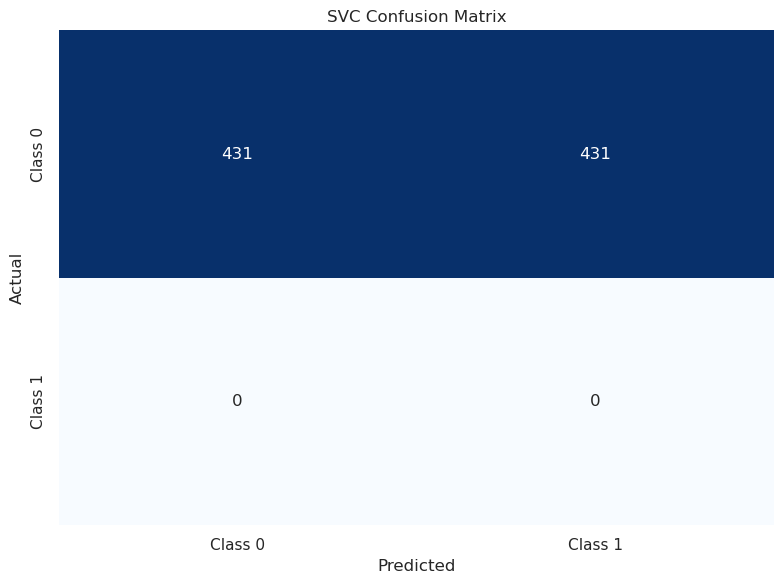

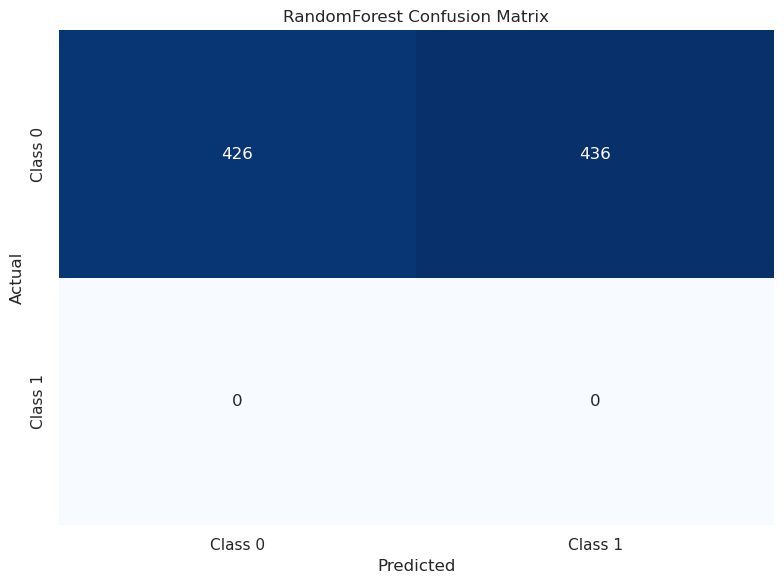

In [71]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, accuracy_score
import seaborn as sns

sns.set_style("whitegrid")

# Define validation parameters
validation_duration = 5.0
validation_offset = duration + validation_duration

# Load and extract MFCCs for validation
validation_fnames = fnames
validation_mfccs = load_and_extract_mfcc(validation_fnames, n_desc, validation_duration, offset=validation_offset)
validation_targets = [np.zeros(mfccs.shape[0]//2, dtype=int), np.ones(mfccs.shape[0]//2, dtype=int)]
validation_data = create_dataframe(validation_mfccs, validation_targets)

X_validation = validation_data.drop('target', axis=1)
y_validation = validation_data['target']

# Evaluate classifiers on validation data
accuracy_svc_val, report_svc_val, cm_svc_val = evaluate_classifier(svm_clf, X_validation, y_validation)
accuracy_rf_val, report_rf_val, cm_rf_val = evaluate_classifier(rf_clf, X_validation, y_validation)

print(f"SVC Accuracy: {accuracy_svc_val * 100:.2f}%")
print(f"RandomForest Accuracy: {accuracy_rf_val * 100:.2f}%")
print(f"SVC Classification report:\n{report_svc_val}")
print(f"RandomForest Classification report:\n{report_rf_val}")

# Plot confusion matrices
plot_confusion_matrix(cm_svc_val, "SVC Confusion Matrix")
plot_confusion_matrix(cm_rf_val, "RandomForest Confusion Matrix")


### - Partie 6 : Expériences

In [ ]:
# parameters
mfccs_coefs = [4, 8, 16, 32, 64, 128]
fnames = ["./audio/classique/Haydn-String-Quartet.mp3",
          "./audio/classique/Mozart-String-Quartet.mp3",
          "./audio/flamenco/Paco-De-Lucia-Rio-Ancho.mp3",
          "./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3",
          "./audio/punk/Millencolin-No_Cigar.mp3",
          "./audio/punk/The-Offspring-The-Kids-Arent-Alright.mp3"]
n_class_styles = [0, 0, 1, 1, 2, 2]
n_class = range(6)
train_durations = [2.0, 5.0, 10.0, 20.0, 30.0, 45.0]
test_duration = 5.0

def get_targets(mfccs, n_class) :
    return [np.full(mfccs[i].shape[0], dtype=int, fill_value=i) for i in n_class]
    

def fine_tune_SVC(mfccs_coefs, train_durations, n_class, test_duration) :
    precision_list, recall_list, n_desc_list, train_duration_list = [], [], [], []

    # Fine tuning loop
    for n_desc in mfccs_coefs :
        for train_duration in train_durations :
            print(f"params : {n_desc} coefs; {train_duration} training seconds.")
            mfccs = get_norm_mfcc(fnames, n_desc, duration)
            targets = get_targets(mfccs, n_class)
            data = create_df(mfccs, targets)
            svm_clf = trained_SVC(data)
            
            test_mfccs = get_norm_mfcc(fnames, n_desc, test_duration, offset=train_duration)
            test_targets = get_targets(test_mfccs, n_class)
            test_data = create_df(test_mfccs, test_targets)

            X_test = test_data.drop('target', axis=1)
            y_test = test_data['target']
            y_pred = svm_clf.predict(X_test)
        
            n_desc_list.append(n_desc)
            train_duration_list.append(train_duration)
            precision_list.append(precision_score(y_test, y_pred, average='weighted'))
            recall_list.append(recall_score(y_test, y_pred, average='weighted'))
            
    return precision_list, recall_list, n_desc_list, train_duration_list
        


precision_list, recall_list, n_desc_list, train_duration_list = fine_tune_SVC(mfccs_coefs, train_durations, n_class, test_duration)

params : 4 coefs; 2.0 training seconds.
params : 4 coefs; 5.0 training seconds.
params : 4 coefs; 10.0 training seconds.
params : 4 coefs; 20.0 training seconds.
params : 4 coefs; 30.0 training seconds.
params : 4 coefs; 45.0 training seconds.
params : 8 coefs; 2.0 training seconds.
params : 8 coefs; 5.0 training seconds.
params : 8 coefs; 10.0 training seconds.
params : 8 coefs; 20.0 training seconds.
params : 8 coefs; 30.0 training seconds.
params : 8 coefs; 45.0 training seconds.
params : 16 coefs; 2.0 training seconds.
params : 16 coefs; 5.0 training seconds.
params : 16 coefs; 10.0 training seconds.
params : 16 coefs; 20.0 training seconds.
params : 16 coefs; 30.0 training seconds.
params : 16 coefs; 45.0 training seconds.
params : 32 coefs; 2.0 training seconds.
params : 32 coefs; 5.0 training seconds.
params : 32 coefs; 10.0 training seconds.
params : 32 coefs; 20.0 training seconds.
params : 32 coefs; 30.0 training seconds.
params : 32 coefs; 45.0 training seconds.
params : 64 

,n_desc,train_duration,precision,recall
31,128,5.0,0.945650,0.938902
32,128,10.0,0.942079,0.931941
30,128,2.0,0.899814,0.886311
25,64,5.0,0.867260,0.851121
26,64,10.0,0.842289,0.820186
24,64,2.0,0.766602,0.715391
19,32,5.0,0.688100,0.699149
20,32,10.0,0.682213,0.658933
33,128,20.0,0.620553,0.519335
18,32,2.0,0.594050,0.591647


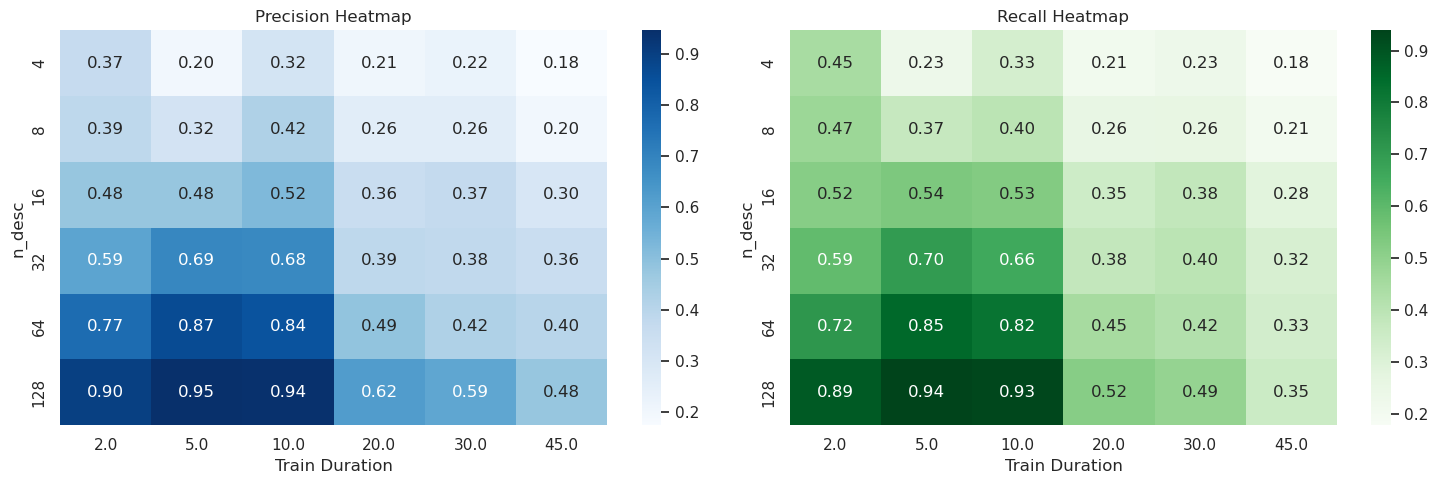

In [ ]:

def plot_fine_tune_results(precision_list, recall_list, n_desc_list, train_duration_list) :
    result_df = pd.DataFrame({
        'n_desc': n_desc_list,
        'train_duration': train_duration_list,
        'precision': precision_list,
        'recall': recall_list
    })

    # Pivot DataFrames to create matrices for heatmap
    precision_matrix = result_df.pivot(index='n_desc', columns='train_duration', values='precision')
    recall_matrix = result_df.pivot(index='n_desc', columns='train_duration', values='recall')

    # Plot heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    sns.heatmap(precision_matrix, cmap='Blues', annot=True, fmt='.2f', ax=ax1)
    ax1.set_title('Precision Heatmap')
    ax1.set_xlabel('Train Duration')
    ax1.set_ylabel('n_desc')

    sns.heatmap(recall_matrix, cmap='Greens', annot=True, fmt='.2f', ax=ax2)
    ax2.set_title('Recall Heatmap')
    ax2.set_xlabel('Train Duration')
    ax2.set_ylabel('n_desc')
    plt.tight_layout()
    
    return result_df


result_df = plot_fine_tune_results(precision_list, recall_list, n_desc_list, train_duration_list)

# display sorted results
result_df.sort_values(["precision", "recall"], ascending=False)

### - Bonus : Classification par style de musique, Classic VS Flamenco VS Punk

params : 4 coefs; 2.0 training seconds.
params : 4 coefs; 5.0 training seconds.
params : 4 coefs; 10.0 training seconds.
params : 4 coefs; 20.0 training seconds.
params : 4 coefs; 30.0 training seconds.
params : 4 coefs; 45.0 training seconds.
params : 8 coefs; 2.0 training seconds.
params : 8 coefs; 5.0 training seconds.
params : 8 coefs; 10.0 training seconds.
params : 8 coefs; 20.0 training seconds.
params : 8 coefs; 30.0 training seconds.
params : 8 coefs; 45.0 training seconds.
params : 16 coefs; 2.0 training seconds.
params : 16 coefs; 5.0 training seconds.
params : 16 coefs; 10.0 training seconds.
params : 16 coefs; 20.0 training seconds.
params : 16 coefs; 30.0 training seconds.
params : 16 coefs; 45.0 training seconds.
params : 32 coefs; 2.0 training seconds.
params : 32 coefs; 5.0 training seconds.
params : 32 coefs; 10.0 training seconds.
params : 32 coefs; 20.0 training seconds.
params : 32 coefs; 30.0 training seconds.
params : 32 coefs; 45.0 training seconds.
params : 64 

,n_desc,train_duration,precision,recall
31,128,5.0,0.945650,0.938902
32,128,10.0,0.942079,0.931941
30,128,2.0,0.899814,0.886311
25,64,5.0,0.866910,0.850735
26,64,10.0,0.842289,0.820186
24,64,2.0,0.766244,0.715004
19,32,5.0,0.688100,0.699149
20,32,10.0,0.682213,0.658933
33,128,20.0,0.620553,0.519335
18,32,2.0,0.594050,0.591647


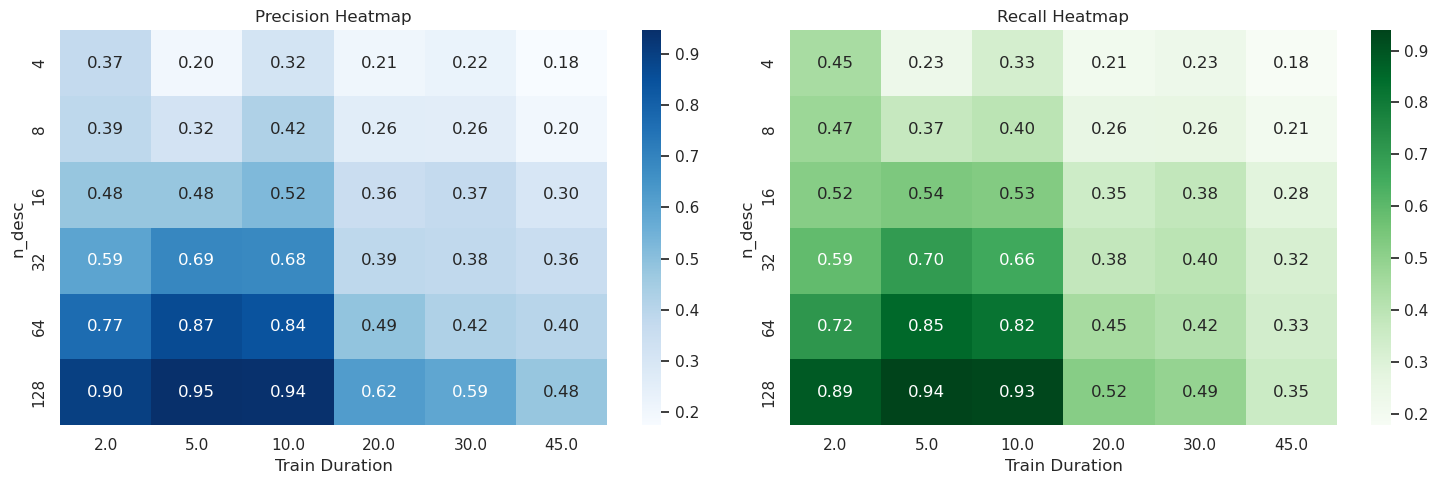

In [ ]:
# parameters
mfccs_coefs = [4, 8, 16, 32, 64, 128]
fnames = ["./audio/classique/Haydn-String-Quartet.mp3",
          "./audio/classique/Mozart-String-Quartet.mp3",
          "./audio/flamenco/Paco-De-Lucia-Rio-Ancho.mp3",
          "./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3",
          "./audio/punk/Millencolin-No_Cigar.mp3",
          "./audio/punk/The-Offspring-The-Kids-Arent-Alright.mp3"]
n_class_styles = [0, 0, 1, 1, 2, 2] # 0 = classique, 1 = flamenco, 2 = punk (we can also use onehot encoding for this)
train_durations = [2.0, 5.0, 10.0, 20.0, 30.0, 45.0]
test_duration = 5.0

precision_list, recall_list, n_desc_list, train_duration_list = fine_tune_SVC(mfccs_coefs, train_durations, n_class, test_duration)
result_df = plot_fine_tune_results(precision_list, recall_list, n_desc_list, train_duration_list)

# display sorted results
result_df.sort_values(["precision", "recall"], ascending=False)

### - Bonus : Unsupervised Learning, clusters de chaque style de musique

,PCA1,PCA2,songs
0,1.934165,-0.208460,1
1,1.080893,-0.428731,5
2,0.370559,-0.377973,2
3,-0.039901,1.021222,0
4,1.193143,-1.435409,4
...,...,...,...
62011,-1.215720,2.151918,4
62012,2.766382,-5.676613,2
62013,-2.358695,0.286499,4
62014,0.637051,-1.322367,0


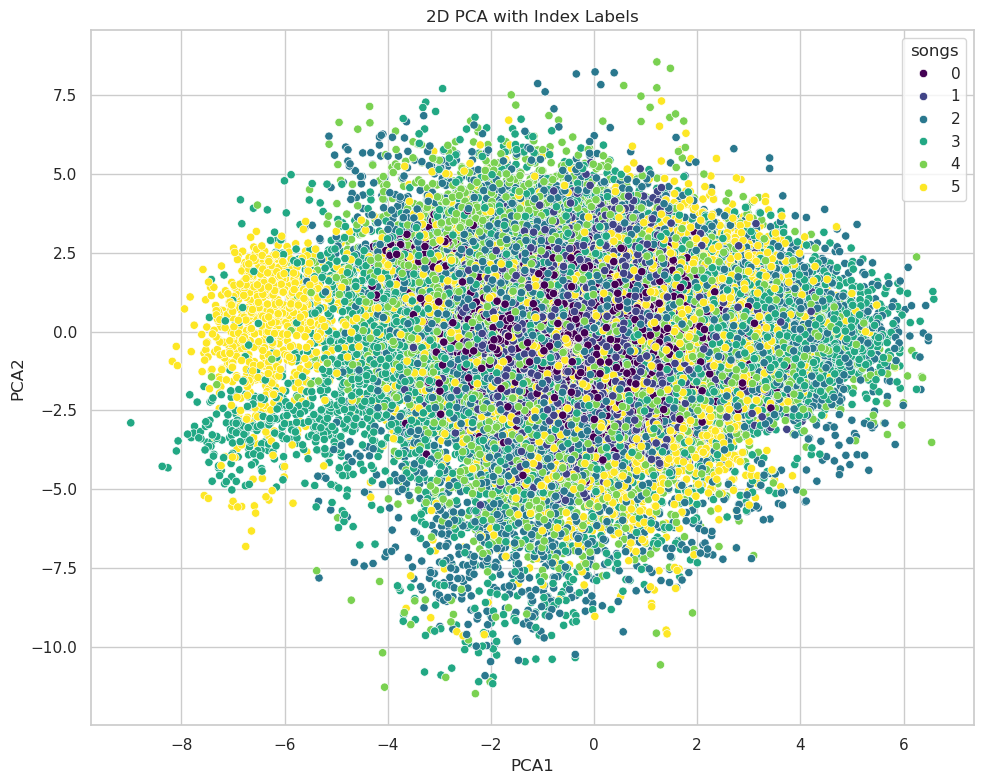

In [ ]:
from sklearn.decomposition import PCA

Best_params = {'mfcc_coef' : 128, 'train_duration' : 120.0}

mfccs_2 = get_norm_mfcc(fnames, Best_params['mfcc_coef'], Best_params['train_duration'])
targets_2 = get_targets(mfccs_2, n_class)
data_2 = create_df(mfccs_2, targets_2)

# Extracting features
features = data_2.drop('target', axis=1)
target = data_2['target']
pca = PCA(n_components=2)

def apply_PCA_to_features(pca, features, target_column) :

    # Applying PCA
    pca_result = pca.fit_transform(features)

    # Creating a new DataFrame with PCA results and target labels
    pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
    pca_df['songs'] = target_column

    mean_by_target = pca_df#.groupby('songs').mean() # calculate mean to get the coordinates of style
    
    # Plotting using Seaborn with whitegrid style
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PCA1', y='PCA2', hue='songs', data=mean_by_target, palette='viridis')
    plt.title('2D PCA with Index Labels')
    plt.tight_layout()
    
    return mean_by_target

pca_df = apply_PCA_to_features(pca, features, target)

pca_df